In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import models

In [12]:
from torchvision import datasets, transforms

batch_size = 100
test_batch_size = 10


transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=False)


In [13]:
def train(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += (pred.eq(target.view_as(pred))*(c.exp()>0.5)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    return correct, av_conf

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [15]:
model = torch.load('base_model.pth').to(device)

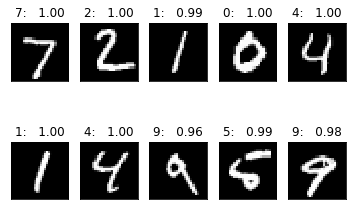

In [16]:
import matplotlib.pyplot as plt
data = enumerate(test_loader).__next__()[1][0]
model.eval()
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
#plt.show()

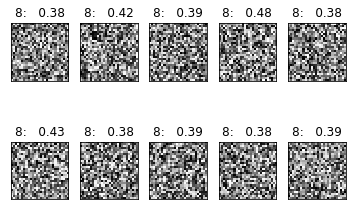

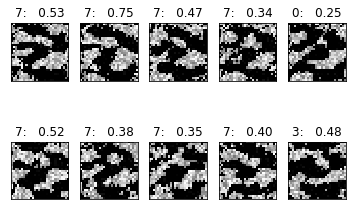

In [94]:
noise = (2*data.mean()*torch.rand((10,1,28,28)))
y = model(noise.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(noise[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()
    
noise = noise.to(device).requires_grad_()
y = model(noise)
loss = y.sum()

loss.backward()

epsilon = .2
image = noise[0]
for _ in range(3):
    
    perturbed_image = noise + epsilon*noise.grad.sign()
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    delta = perturbed_image
    perturbed_image = perturbed_image.detach()



model.eval()
y = model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [18]:
def generate_adv_noise(model, epsilon, batch_size=10, norm=2, num_of_it=10, alpha=0.01):
    image = (.22*torch.rand((batch_size,1,28,28)))
    image = image.to(device).requires_grad_()

    perturbed_image = image
    for _ in range(num_of_it):
        y = model(perturbed_image)
        loss = -y.sum()
        loss.backward()

        with torch.no_grad():
            perturbed_image += alpha*image.grad

            delta = perturbed_image-image
            delta /= delta.view((batch_size,784)).norm(dim=1)[:,None,None,None]
            delta *= epsilon
            perturbed_image = image + delta
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
            #print(str(loss.item()) + '\t'+ str((perturbed_image-image).view((10,784)).norm(dim=1).max().item()))
            perturbed_image = perturbed_image.detach()
    return perturbed_image

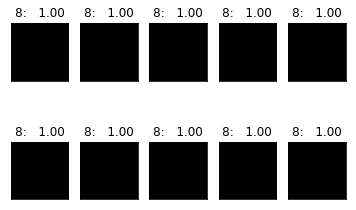

In [30]:
model.eval()
perturbed_image = generate_adv_noise(model, 35)
y = model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [72]:
robust_model = torch.load('robust_model.pth')

In [73]:
robust_model.eval()
perturbed_image = generate_adv_noise(robust_model, 3)
y = robust_model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

249.24517822265625	25.495637893676758
230.26123046875	7.000000953674316
230.26220703125	7.000000476837158
230.2623291015625	7.000000476837158
230.2623291015625	7.000000953674316
230.2618408203125	7.000001430511475
230.26129150390625	7.000000476837158
230.26080322265625	7.000000476837158
230.26177978515625	7.000000953674316
230.2628173828125	7.000001430511475


In [36]:
model(torch.ones((10,1,28,28)).to(device)).exp().max(dim=1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'))

In [70]:
robust_model.gmm(perturbed_image.view(10,784)).max(dim=0)

(tensor([-753.4155, -753.1851, -753.4005, -753.7383, -753.0765, -753.8444,
         -753.5245, -753.8726, -753.0617, -752.7513], device='cuda:0',
        grad_fn=<MaxBackward0>),
 tensor([904, 904, 904, 904, 904, 904, 904, 904, 904, 904], device='cuda:0'))